In [ ]:
import os
import glob
import cv2
import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf # type: ignore
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D, ReLU # type: ignore
from tensorflow.keras.layers import MaxPool2D, Concatenate, Activation, BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

import warnings
warnings.filterwarnings('ignore')

In [ ]:
WIDTH, HEIGHT, CHANNEL = 256, 256, 3
TRAIN_RATIO, VALIDATION_RATIO, TEST_RATIO = 0.70, 0.15, 0.15
DATASET_PATH = "/content/drive/MyDrive/DATASET"
WEIGHTS_DIR = "model/weights/"
MODEL_DIR = "model/models/"
# source: https://www.kaggle.com/datasets/faizalkarim/flood-area-segmentation

In [ ]:
image_paths =  sorted(glob.glob('/content/drive/MyDrive/DATASET/Image/*.jpg'))
mask_paths = sorted(glob.glob('/content/drive/MyDrive/DATASET/Mask/*.png'))
# len(images), len(masks)

# image_paths = sorted(image_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
# mask_paths  = sorted(mask_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

len(image_paths), len(mask_paths)

(290, 290)

In [ ]:
def pre_process(img_paths, channel):
    images = [Image.open(p).convert(channel).resize((WIDTH, HEIGHT)) for p in img_paths]
    images = np.array(images, dtype=np.float32) / 255.
    return images

images_normalized = pre_process(image_paths, 'RGB')
mask_normalized = pre_process(mask_paths, 'L').reshape(len(mask_paths), WIDTH, HEIGHT, 1)

images_normalized.shape, mask_normalized.shape

((290, 256, 256, 3), (290, 256, 256, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_normalized, mask_normalized,
                                                    test_size = 1-TRAIN_RATIO,shuffle=False)
X_val,   X_test, y_val,   y_test = train_test_split(X_test, y_test, shuffle=False,
                                                    test_size = TEST_RATIO/(TEST_RATIO+VALIDATION_RATIO))

print(X_train.shape, y_train.shape,'\n',
      X_test.shape,  y_test.shape,'\n',
      X_val.shape,   y_val.shape)

(202, 256, 256, 3) (202, 256, 256, 1) 
 (44, 256, 256, 3) (44, 256, 256, 1) 
 (44, 256, 256, 3) (44, 256, 256, 1)


In [ ]:
def display_images(img1, img2, img3, title=True):
    row, col = 1, 3
    plt.subplots(row, col, dpi=200)

    plt.subplot(row, col, 1)
    if(title):plt.title("Image")
    plt.imshow(np.clip(img1, 0, 1))
    plt.axis('off')

    plt.subplot(row, col, 2)
    if(title):plt.title("Mask")
    plt.imshow(np.clip(img2, 0, 1))
    plt.axis('off')

    plt.subplot(row, col, 3)
    if(title):plt.title("Predicted")
    plt.imshow(np.clip(img3, 0, 1))
    plt.axis('off')

    plt.show()

In [ ]:
def overlay(image, mask, color, alpha):
    masked_image = image.copy()

    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)

    masked = np.ma.MaskedArray(masked_image, mask=colored_mask, fill_value=color)

    image_overlay = masked.filled()
    image_combined = cv2.addWeighted(masked_image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [ ]:
def psnr(img1, img2):
    return tf.image.psnr(img1, img2, max_val=255).numpy()

def ssim(img1, img2):
    return tf.image.ssim(img1, img2, max_val=255).numpy()

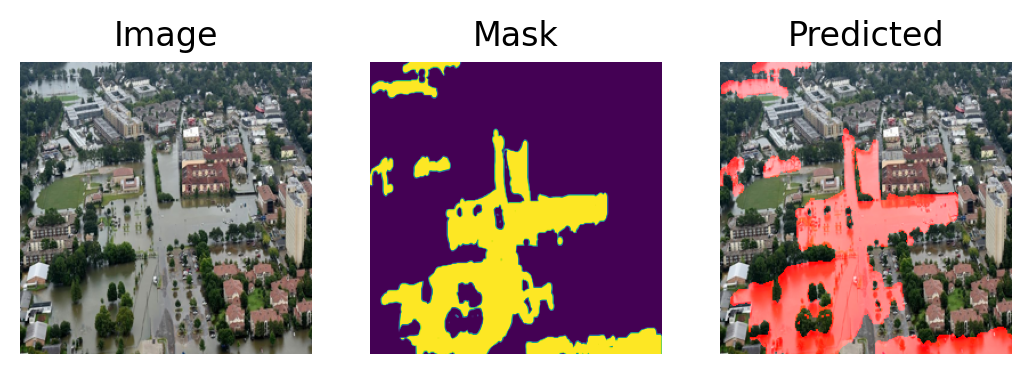

In [ ]:
rnd_img_idx = random.randint(0, len(X_train))
X_img = X_train[rnd_img_idx,:,:,:]
y_img = y_train[rnd_img_idx,:,:,:]

y_img_overlay = overlay(X_img, y_img, color=(255,0,0), alpha=0.1) # type: ignore
display_images(X_img, y_img, y_img_overlay, title=True) # type: ignore

In [ ]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(inputs) # https://keras.io/api/layers/initializers/
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

In [ ]:
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D(pool_size=(2,2))(x)
    return x, p

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(filters=num_filters, kernel_size=(2,2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [ ]:
def UNet(input_size):
    input_layer_nodes = 8
    input = Input(input_size)
    # s: output of conv block | p: output of max pooling
    s1, p1 = encoder_block(input,input_layer_nodes * 1)
    s2, p2 = encoder_block(p1,   input_layer_nodes * 2)
    s3, p3 = encoder_block(p2,   input_layer_nodes * 4)
    s4, p4 = encoder_block(p3,   input_layer_nodes * 8)

    b1 = conv_block(p4, input_layer_nodes * 16)   # Bridge

    # d: output of decoder block
    d1 = decoder_block(b1, s4, input_layer_nodes * 8)
    d2 = decoder_block(d1, s3, input_layer_nodes * 4)
    d3 = decoder_block(d2, s2, input_layer_nodes * 2)
    d4 = decoder_block(d3, s1, input_layer_nodes * 1)

    output = Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(d4)

    return tf.keras.Model(input, output, name="U-Net")

In [ ]:
unet = UNet((WIDTH, HEIGHT, CHANNEL))
unet.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])
unet.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 8)    │            224 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 8)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 8)    │            584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 8)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 16)   │          1,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 16)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 16)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 32)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 64)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 485,817 (1.85 MB)

 Trainable params: 485,817 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save model and logs on training with callbacks

checkpoints_path = "model/checkpoints/model-improvement-{epoch:02d}-{val_acc:.2f}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoints_path, verbose = 1,
                                                monitor='val_acc', save_best_only = True, mode='max',  # vall_acc arttıkça kaydet.
                                                #monitor='loss', save_best_only = True, mode='min',    # loss azaldıkça kaydet.
                                                #save_weights_only=True,                               # sadece weight'leri kaydet.
                                                )

early_stop = tf.keras.callbacks.EarlyStopping(patience = 5, # Monitorde artış olmayan epoch sayısı
                                              verbose = 1, monitor = 'val_loss')

log_csv = tf.keras.callbacks.CSVLogger(os.getcwd() + '\\logs\\train_log.csv', separator=',', append=True)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir = os.getcwd() + '\\logs', write_images=True, histogram_freq=2,
                                             write_steps_per_second=True, update_freq='epoch',)

"""from torch.utils.tensorboard import SummaryWriter
model = ...
dummy_input = ...
writer = SummaryWriter(f'logs/graph')
writer.add_graph(model, dummy_input)
writer.close()"""

callback_list = [checkpoint, tensorboard, log_csv]

In [ ]:
results = unet.fit(
    X_train,
    y_train,
    batch_size = 32,
    epochs = 100,
    #validation_split = 0.1,
    validation_data = (X_val, y_val),
    callbacks = callback_list
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.4687 - loss: 0.6936   
Epoch 1: val_acc improved from -inf to 0.56957, saving model to model/checkpoints/model-improvement-01-0.57.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - acc: 0.4734 - loss: 0.6935 - val_acc: 0.5696 - val_loss: 0.6894
Epoch 2/100


acc: 0.8801971077919006 val_acc 0.8598716259002686


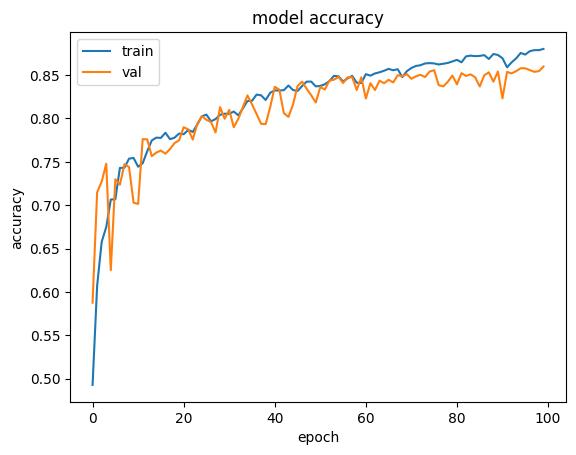

In [ ]:
print("acc:", results.history['acc'][-1], "val_acc", results.history['val_acc'][-1])

plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

loss: 0.23214423656463623 val_acc 0.2891620099544525


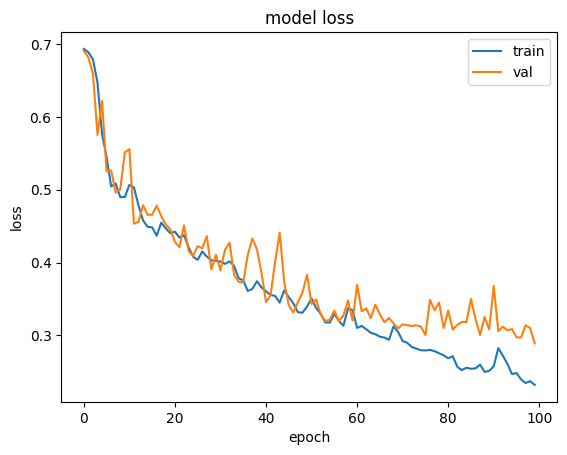

In [ ]:
print("loss:", results.history['loss'][-1], "val_acc", results.history['val_loss'][-1])

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [ ]:
results = unet.evaluate(X_test, y_test, batch_size=1)
print("loss:", results[0], "acc:", results[1])

44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - acc: 0.8542 - loss: 0.3410
loss: 0.2890779674053192 acc: 0.8710933923721313


In [ ]:
idx = random.randint(0, len(X_train))

preds_train = unet.predict(X_train)
preds_val   = unet.predict(X_val)
preds_test  = unet.predict(X_test)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t   = (preds_val   > 0.5).astype(np.float32)
preds_test_t  = (preds_test  > 0.5).astype(np.float32)

In [ ]:
preds_train_t.shape, preds_val_t.shape, preds_test_t.shape

((202, 256, 256, 1), (44, 256, 256, 1), (44, 256, 256, 1))

PSNR: 59.47295 | SSIM: 0.99356735


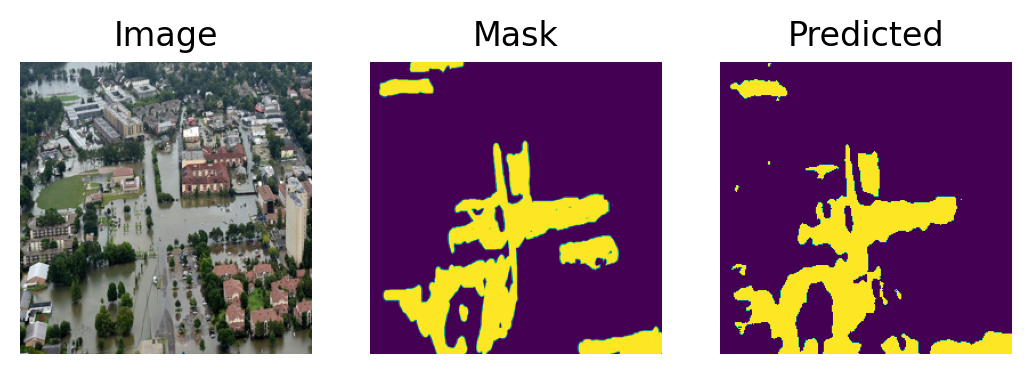

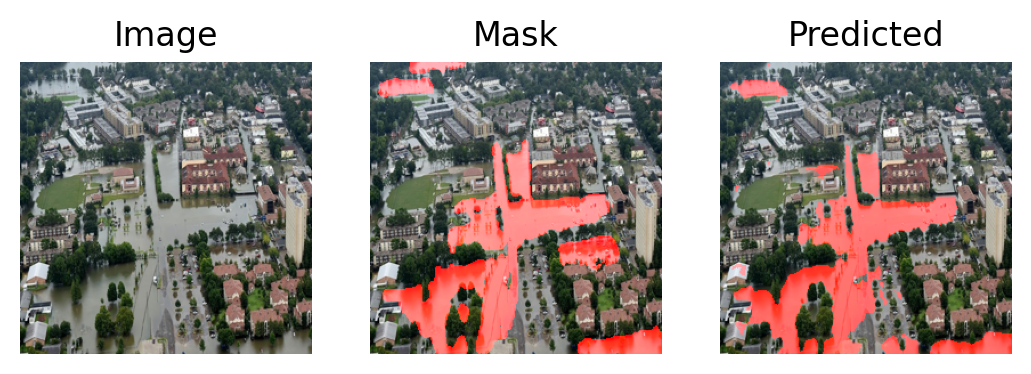

In [ ]:
import random
# Select a random index from training set
i = random.randint(0, len(preds_train_t))

print("PSNR:", psnr(y_train[i], preds_train_t[i]), '|',
      "SSIM:", ssim(y_train[i], preds_train_t[i]))

display_images(X_train[i], y_train[i], preds_train_t[i])

y_train_overlay = overlay(X_train[i], y_train[i],       color=(255,0,0), alpha=0.1)
y_pred_overlay  = overlay(X_train[i], preds_train_t[i], color=(255,0,0), alpha=0.25)

display_images(X_train[i], y_train_overlay, y_pred_overlay)
